In [1]:
import numpy as np
import BigFunctions as BF
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import uproot as ur
#%matplotlib tk

In [2]:
#Reading the variables

input_path = "../data/bigdata_CFD_19092024_0001.root"
with ur.open(input_path) as file:
    outTree = file["DataTree"]
    label = outTree["label"].array(library = "np")
    time = outTree["time"].array(library = "np")*10**-6   #[µs]
    nrj = outTree["nrj"].array(library = "np")
    pileup = outTree["pileup"].array(library = "np")

print("Duration of the data acquisition:", max(time)*10**(-6)/3600, "hours")
print("Number of events acquired:", len(label)/10**6, "million")

Duration of the data acquisition: 24.165920764844568 hours
Number of events acquired: 27.163923 million


In [3]:
#Correlation

corr_t = 5*10**-3   #Correlation window
corr_mask = (time[1:]-time[:-1]<corr_t) & (label[1:] != label[:-1])

correl_both = (np.insert(corr_mask,0,False))|(np.append(corr_mask,False))
del(corr_mask)

t = time[correl_both]
l = label[correl_both]
p = pileup[correl_both]
e = nrj[correl_both]

t1 = time[correl_both & (label==1)]
t2 = time[correl_both & (label==2)]
nrj1 = nrj[correl_both & (label==1)]
nrj2 = nrj[correl_both & (label==2)]

dt2 = t2[1:]-t2[:-1]
dt1 = t1[1:]-t1[:-1]

print("Number of events after correlation:       ", len(t)/10**6, "million")
print("Dead time:                                ", min(dt2), "µs")
print("Total number of pileups:                  ", len(pileup[pileup == True]))
print("Total number of pileups after correlation:", len(p[p == True]))

Number of events after correlation:        14.769676 million
Dead time:                                 0.15856170654296875 µs
Total number of pileups:                   0
Total number of pileups after correlation: 0


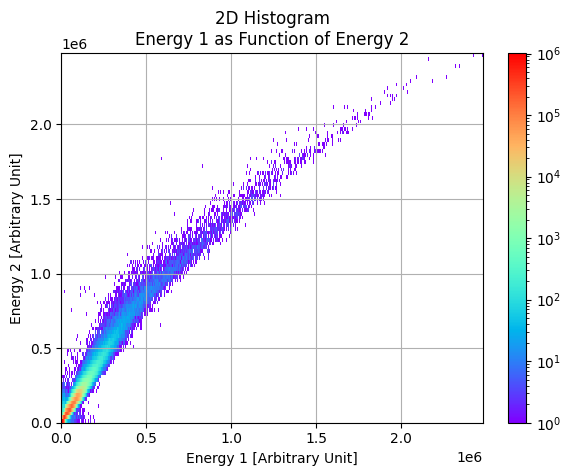

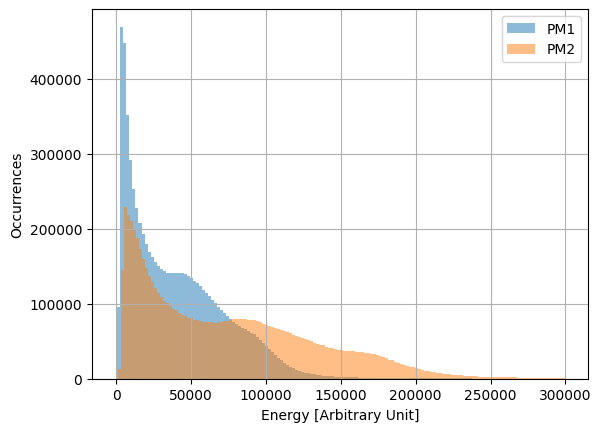

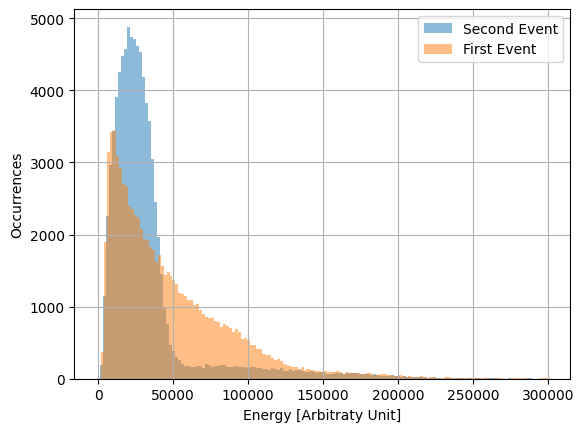

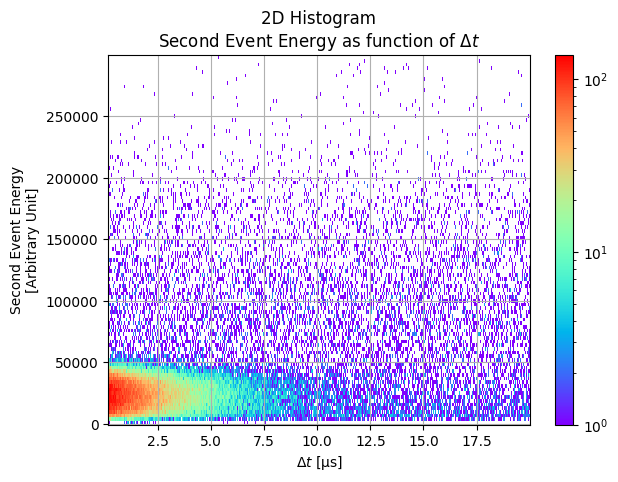

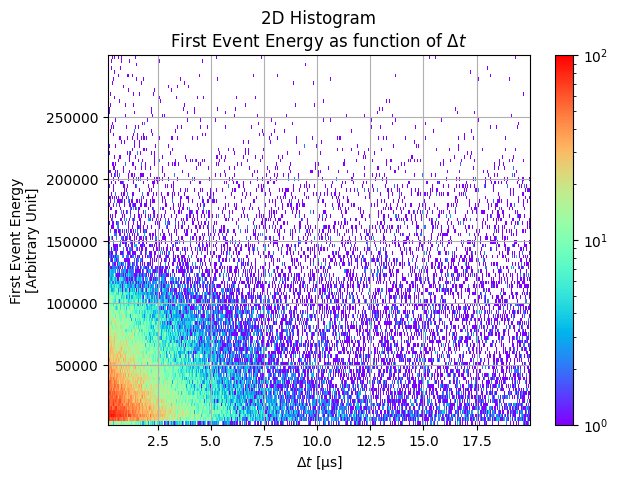

In [16]:
#Energy Analysis

nrj_max = 300000
dt_max = 20

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(nrj1, nrj2, bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('Energy 1 [Arbitrary Unit]')
ax1.set_ylabel('Energy 2 [Arbitrary Unit]')
ax1.set_title('2D Histogram\nEnergy 1 as Function of Energy 2')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

plt.figure()
plt.hist(nrj1[nrj1 < nrj_max], bins = 150, alpha = 0.5, label = "PM1")
plt.hist(nrj2[nrj2 < nrj_max], bins = 150, alpha = 0.5, label = "PM2")
plt.xlabel("Energy [Arbitrary Unit]")
plt.ylabel("Occurrences")
plt.grid()
plt.legend()
plt.show()

plt.figure()
#plt.hist(nrj2[1:][(nrj2[1:]<nrj_max) & (dt2<dt_max)], bins=150, label="Second Event", alpha = 0.5)
#plt.hist(nrj2[:-1][(nrj2[:-1]<nrj_max)  & (dt2<dt_max)], bins=150, label="First Event", alpha = 0.5)
plt.hist(nrj2[(nrj2<nrj_max) & (np.insert(dt2, 0, np.nan)<dt_max)], bins=150, label="Second Event", alpha = 0.5)
plt.hist(nrj2[(nrj2<nrj_max) & (np.append(dt2, np.nan)<dt_max)], bins=150, label="First Event", alpha = 0.5)
plt.xlabel('Energy [Arbitraty Unit]')
plt.ylabel('Occurrences')
plt.legend()
plt.grid()
plt.show()

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(nrj2[1:]<nrj_max) & (dt2<dt_max)], 
                                 nrj2[1:][(nrj2[1:]<nrj_max) & (dt2<dt_max)],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('Second Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nSecond Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

fig, ax1 = plt.subplots(1, sharex=True)
arr_1,xe_1,ye_1 = np.histogram2d(dt2[(nrj2[:-1]<nrj_max) & (dt2<dt_max)], 
                                 nrj2[:-1][(nrj2[:-1]<nrj_max) & (dt2<dt_max)],
                                 bins =(500,100))
pcm_1 = ax1.pcolormesh(xe_1, ye_1,arr_1.T, cmap='rainbow', norm=LogNorm(vmin=arr_1.min()+1, vmax=arr_1.max()))
ax1.set_xlabel('$\Delta t$ [µs]')
ax1.set_ylabel('First Event Energy\n[Arbitrary Unit]')
ax1.set_title('2D Histogram\nFirst Event Energy as function of $\Delta t$')
ax1.grid()
fig.colorbar(pcm_1, ax=ax1, orientation='vertical', fraction=.1)
plt.show()

/home/hind/Documents/Cours/Cours M2/TL/BigMuoneXperiment/BigFunctions.py:5: RuntimeWarning: overflow encountered in exp
  def exp2(t, N0, lam1, lam2, C) : return N0*np.exp(-lam1*t) + 1.3475*N0*np.exp(-lam2*t) + C


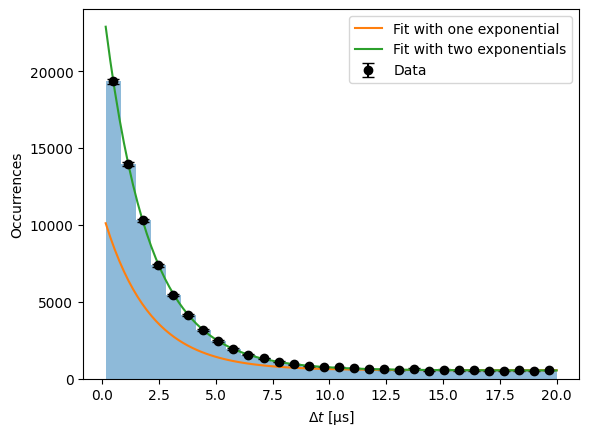

In [30]:
#dt Analysis

dt_max = 20
dt = dt2[dt2 < dt_max]

N_bins = 30
hist = np.histogram(dt, bins = N_bins)
x = hist[1][1:]-(hist[1][1]-hist[1][0])/2
y = hist[0]
y_err = np.sqrt(y)

#Fit----------------------------------------------------

#With one exponential
popt, cov = curve_fit(BF.exp1, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 400]))
N0 = popt[0]
lam = popt[1]
C = popt[2]

#With two exponentials
popt, cov = curve_fit(BF.exp2, x, y, sigma=y_err, absolute_sigma = True, p0 = np.array([20000, 2, 2, 400]))
N0 = popt[0]
lam1 = popt[1]
lam2 = popt[2]
CC = popt[3]

#-------------------------------------------------------

plt.figure()
plt.hist(dt2[dt2 < dt_max], bins = N_bins, alpha = 0.5)
plt.errorbar(x, y, yerr = y_err, linestyle = 'None', fmt='o', capsize=4, c='k', label = 'Data')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp1(np.linspace(min(dt), max(dt), 100), N0, lam, C), 
                     label = 'Fit with one exponential')
plt.plot(np.linspace(min(dt), max(dt), 100), BF.exp2(np.linspace(min(dt), max(dt), 100), N0, lam1, lam2, CC), 
                     label = 'Fit with two exponentials')
plt.xlabel("$\Delta t$ [µs]")
plt.ylabel("Occurrences")
plt.legend()
plt.show()

In [29]:
print(1/lam)
print(1/lam1, 1/lam2)

2.022333889785022
2.4295059152645355 1.6708051549785627
